In [128]:
from datetime import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regress_with_conf_interval as re
from matplotlib.offsetbox import AnchoredText

In [129]:
df_list = []
for i in [0, 3]:
    for j in [45, 60, 75, 90]:
        file_name = f'./data/threads_test/difficulty_{i}_threads{j}/elapseTime.csv' 
        df = pd.read_csv(file_name)
        df_list.append(df)

In [130]:
for i in range(len(df_list)):
    for idx, elapsed_time in enumerate(df_list[i].elapsed_time):
        #print("Elasped time : ", elapsed_time)
        if elapsed_time.find('h') != -1:
            hour, elapsed_time = elapsed_time.split('h')
        else:
            hour = 0.0

        if elapsed_time.find('m') != -1 and elapsed_time.find('ms') == -1:
            minute, elapsed_time = elapsed_time.split('m')
        else:
            minute = 0.0

        if elapsed_time.find('s') != -1 and elapsed_time.find('ms') == -1:
            second, elapsed_time = elapsed_time.split('s')
        else:   
            second = 0.0

        if elapsed_time.find('ms') != -1:
            ms, elapsed_time = elapsed_time.split('ms')
        else:
            ms = 0.0
        
        # print("hour : ", float(hour))
        # print("minute : ", float(minute))
        # print("second : ", float(second))
        # print("ms : ", float(ms))

        df_list[i].elapsed_time[idx] = str(float(hour) * 3600 + float(minute) * 60 + float(second) + float(ms) / 100)

In [131]:
x = df_list[0]['block_height']
y = df_list[0]['elapsed_time']

frame = pd.Series(y, index=list(x - 1))
frame

0       11.313612798
1       23.272238786
2        6.207996282
3       13.532946908
4       11.572586425
            ...     
1495    41.733139346
1496    59.758762172
1497    49.712511657
1498     21.48051938
1499    47.658813767
Name: elapsed_time, Length: 1500, dtype: object

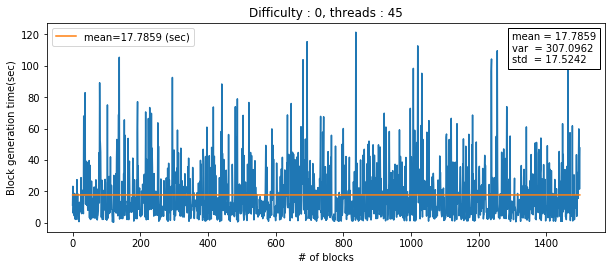

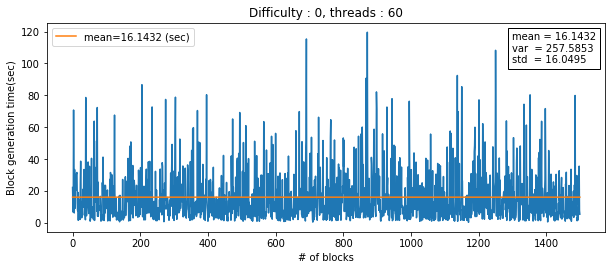

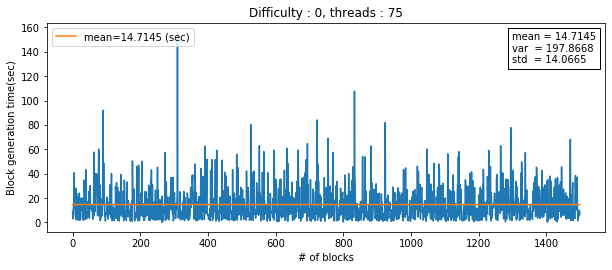

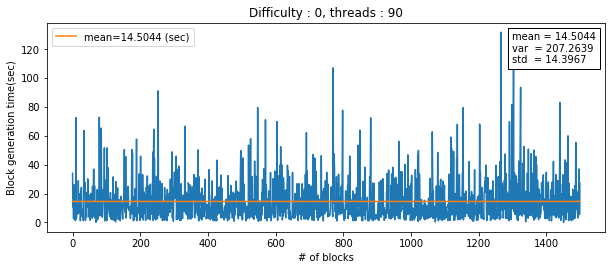

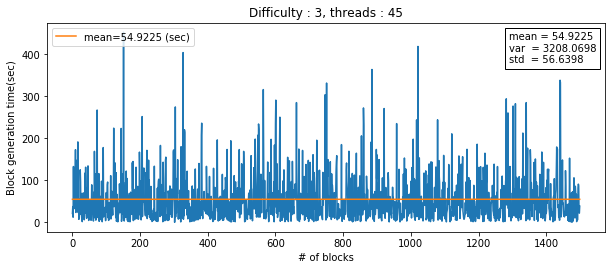

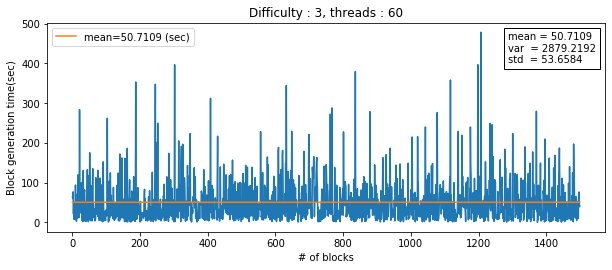

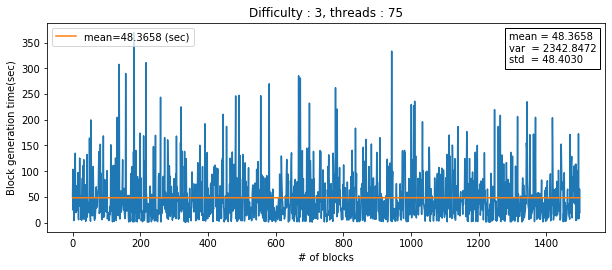

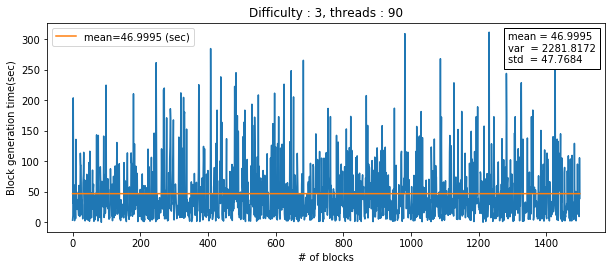

In [132]:
plt.rcParams["figure.figsize"] = (10,50)
difficulty = [0,0,0,0,3,3,3,3]
threads = [45,60,75,90,45,60,75,90]
for i in range(len(df_list)):
    x = df_list[i]['block_height']
    frame = df_list[i]['elapsed_time'].astype(float)
    fig = plt.figure()
    ax = fig.add_subplot(11,1,i+1)    
    mean = pd.Series(frame.mean(), index=list(x))
    ax.set_title(f"Difficulty : {difficulty[i]}, threads : {threads[i]}")
    ax.set_xlabel("# of blocks")
    ax.set_ylabel("Block generation time(sec)")
    ax.plot(frame)
    ax.plot(x-1, mean, label=f"mean={np.array(mean)[0]:.4f} (sec)")
    
    textstr = '\n'.join((
        r'mean = %.4f' % (frame.mean()),
        r'var  = %.4f' % (frame.var()),
        r'std  = %.4f' % (frame.std()))
    )
    textbox = AnchoredText(textstr, loc=1)
    ax.add_artist(textbox)

    plt.legend(loc="upper left")


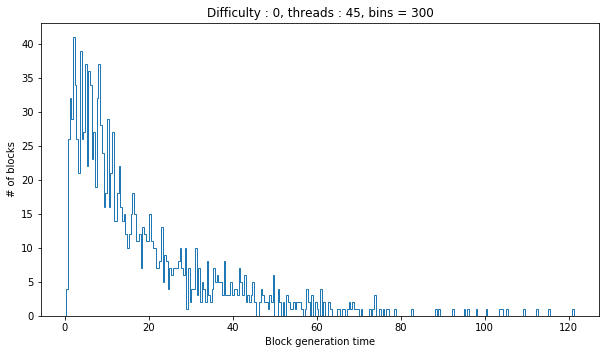

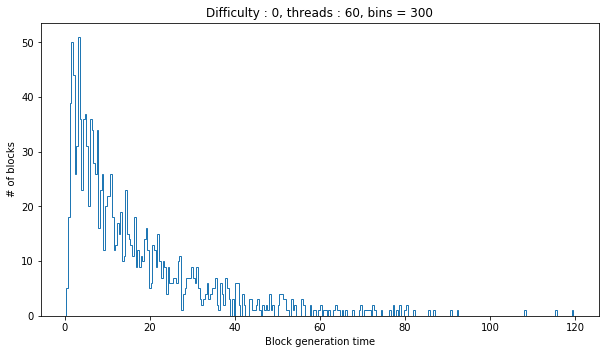

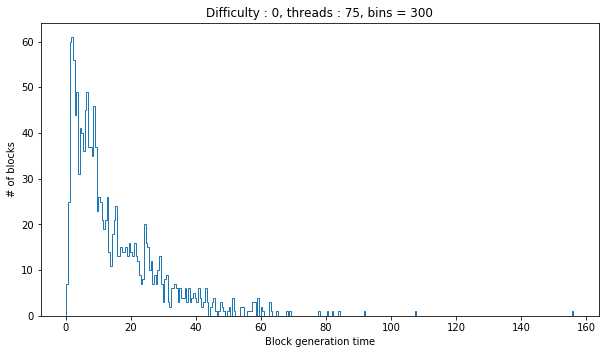

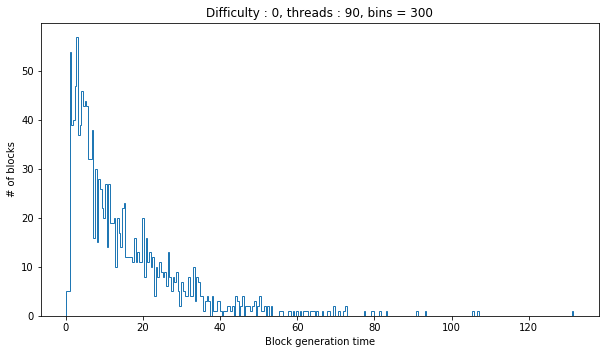

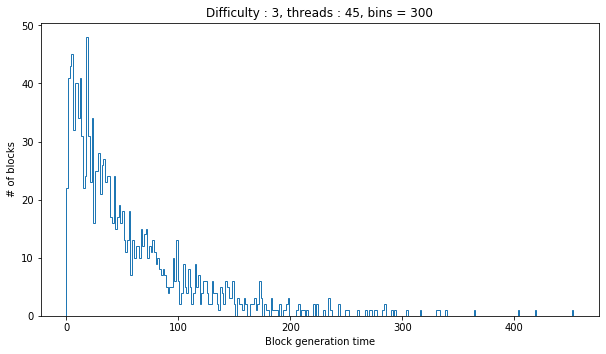

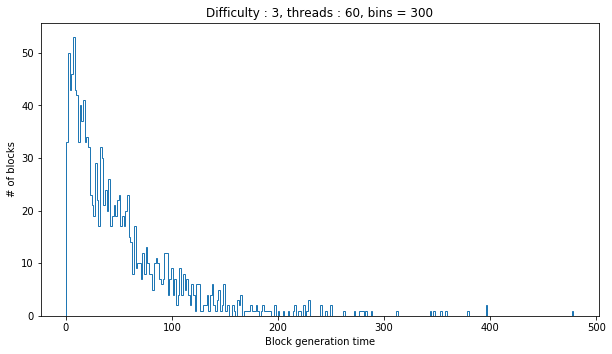

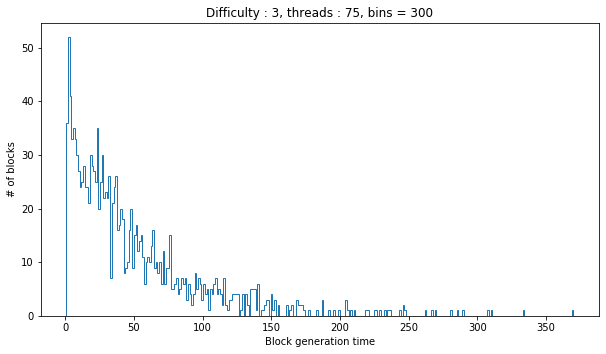

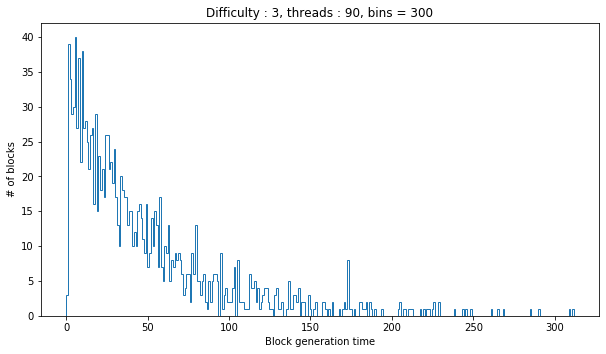

In [133]:
plt.rcParams["figure.figsize"] = (10,70)
num_of_bin = 300
val_list = []
bin_list = []
for i in range(len(df_list)):
    x = df_list[i]['block_height']
    frame = df_list[i]['elapsed_time'].astype(float)
    fig = plt.figure()
    ax = fig.add_subplot(11,1,i+1)    

    ax.set_title(f"Difficulty : {difficulty[i]}, threads : {threads[i]}, bins = {num_of_bin}")
    ax.set_xlabel("Block generation time")
    ax.set_ylabel("# of blocks")
    #plt.hist(frame, bins=num_of_bin, histtype='step')    
    val, bin, _ = plt.hist(frame, bins=num_of_bin, histtype='step')    
    val_list.append(val)
    bin_list.append(bin)
    #plt.legend(loc="upper left")

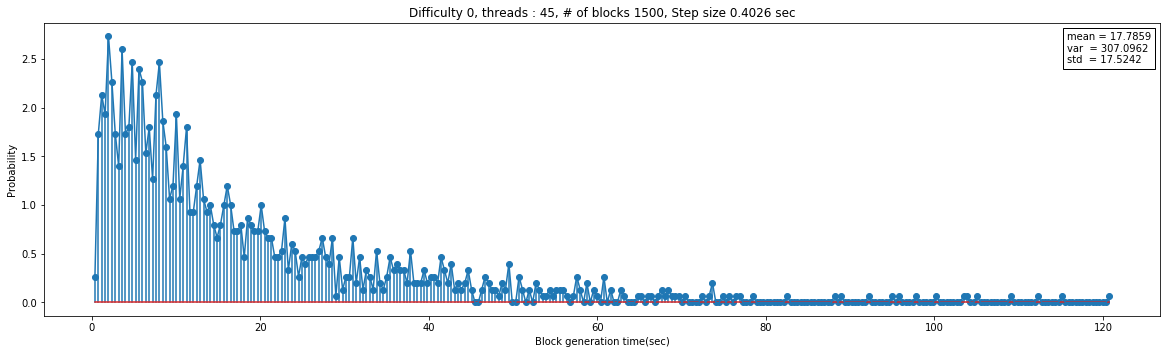

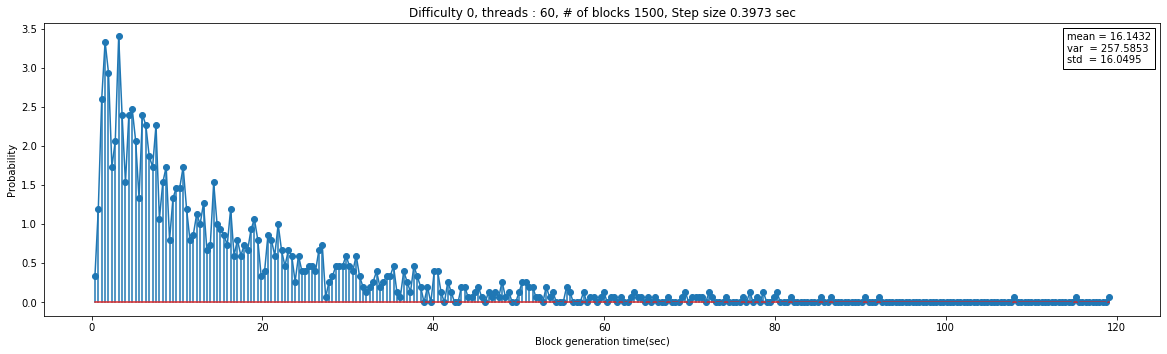

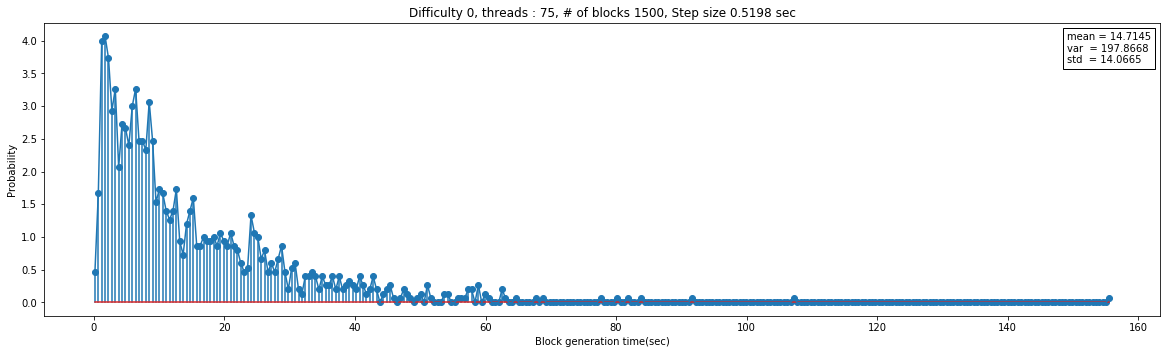

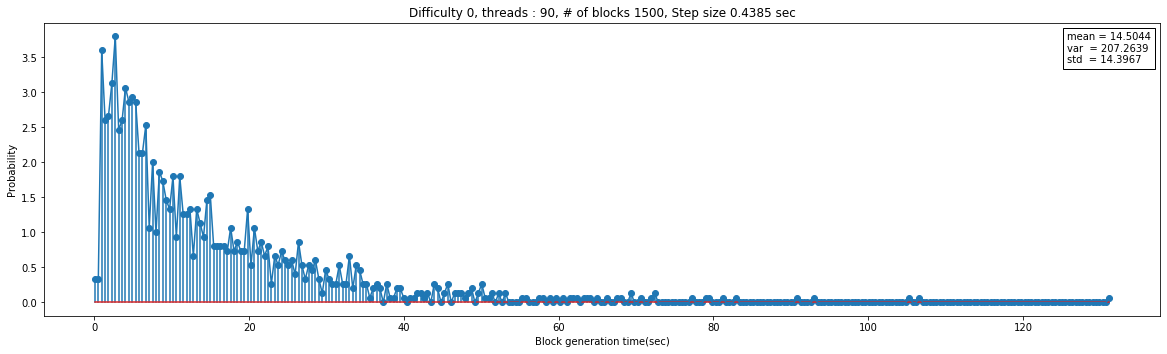

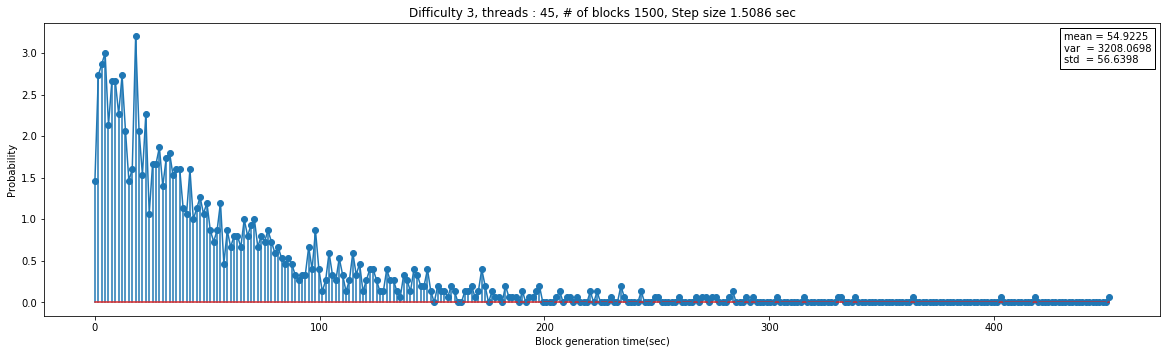

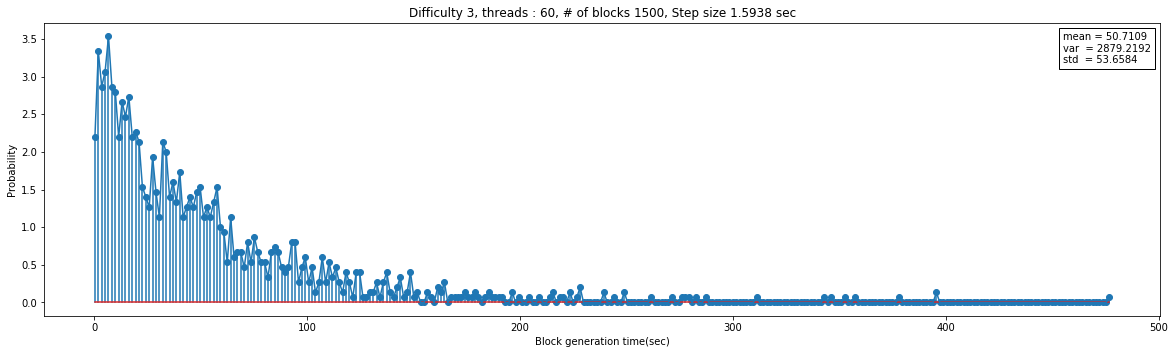

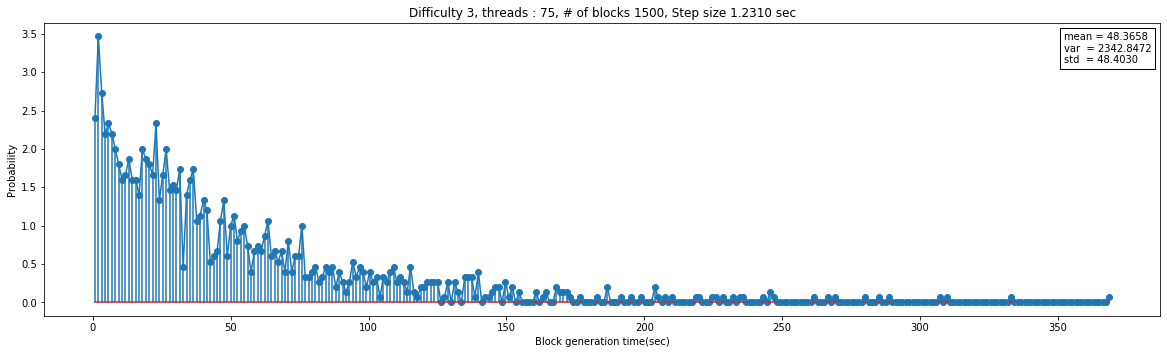

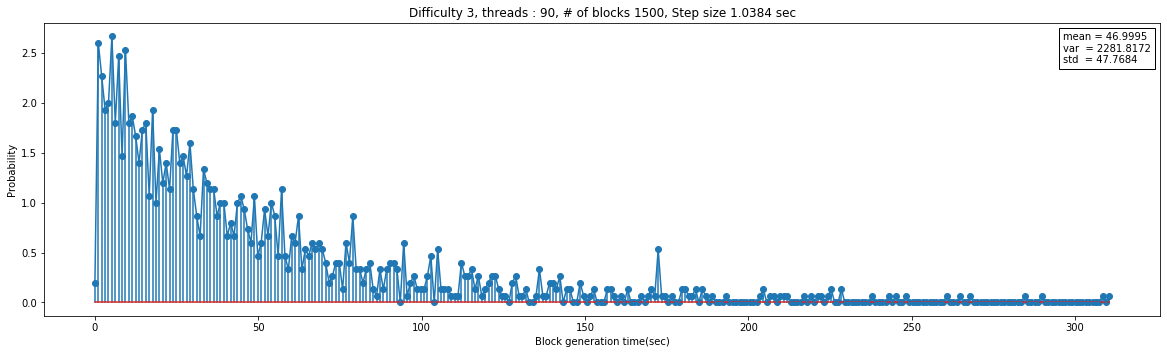

In [134]:
plt.rcParams["figure.figsize"] = (20,70)
for i in range(len(df_list)):
    x = df_list[i]['block_height']
    frame = df_list[i]['elapsed_time'].astype(float)
    fig = plt.figure()
    ax = fig.add_subplot(11,1,i+1)    
    ax.set_title(f"Difficulty {difficulty[i]}, threads : {threads[i]}, # of blocks {len(np.array(frame))}, Step size {bin_list[i][1] - bin_list[i][0]:.4f} sec")
    #Each stick is {max(np.array(frame))/num_of_bin:.4f} sec

    textstr = '\n'.join((
        r'mean = %.4f' % (frame.mean()),
        r'var  = %.4f' % (frame.var()),
        r'std  = %.4f' % (frame.std()))
    )
    textbox = AnchoredText(textstr, loc=1)
    ax.add_artist(textbox)

    ax.set_xlabel("Block generation time(sec)")
    ax.set_ylabel("Probability")
    #plt.hist(frame, bins=num_of_bin, histtype='step')    
    plt.stem(bin_list[i][:-1], val_list[i]*100/sum(val_list[i]))
    plt.plot(bin_list[i][:-1], val_list[i]*100/sum(val_list[i]))
    #plt.legend(loc="upper left")

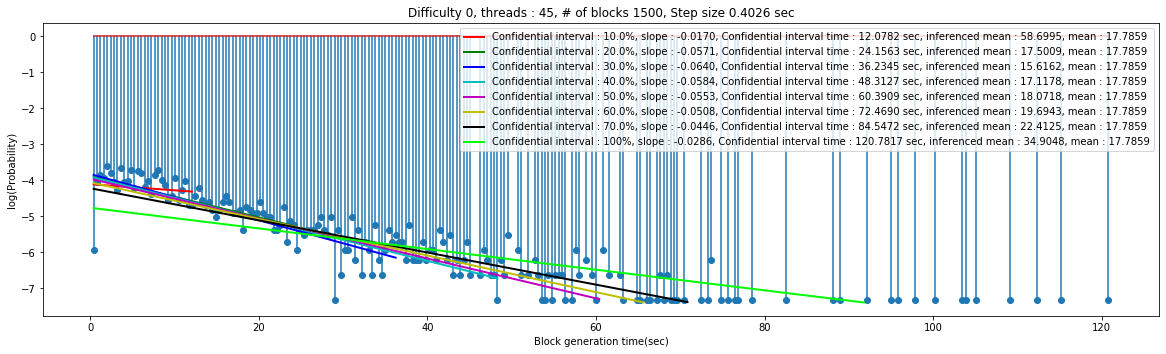

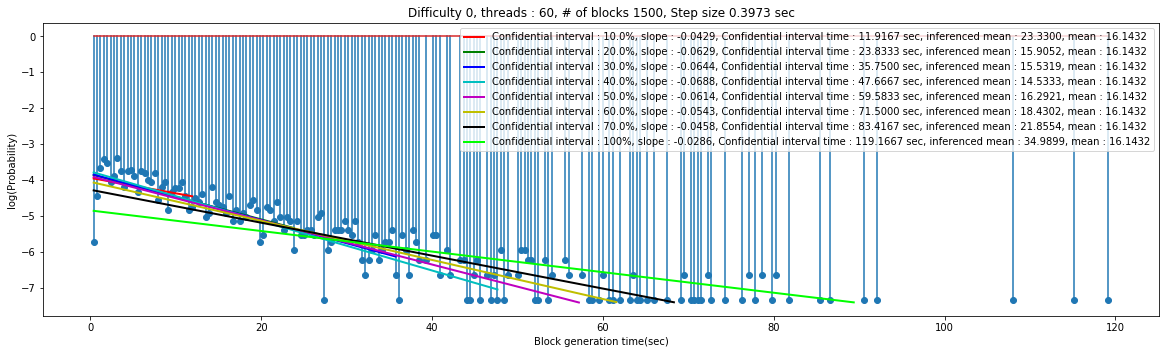

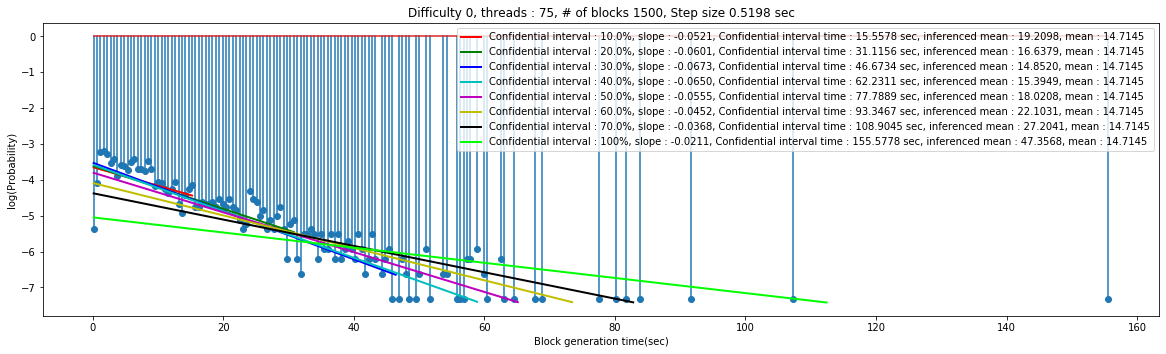

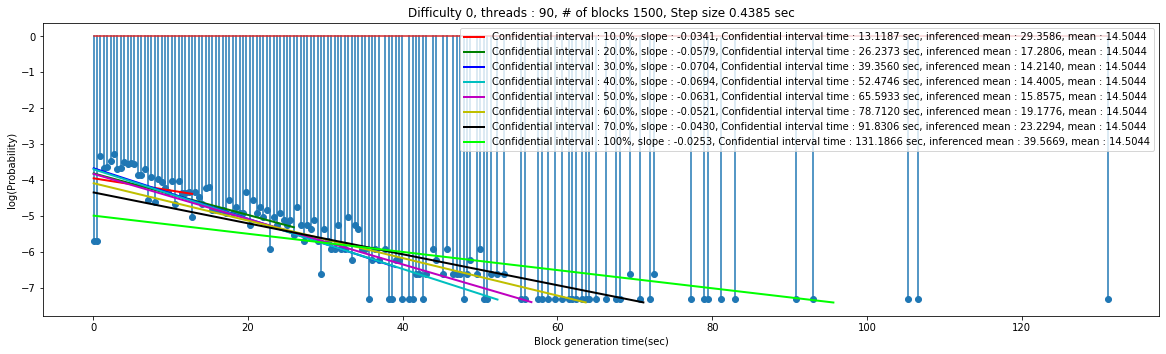

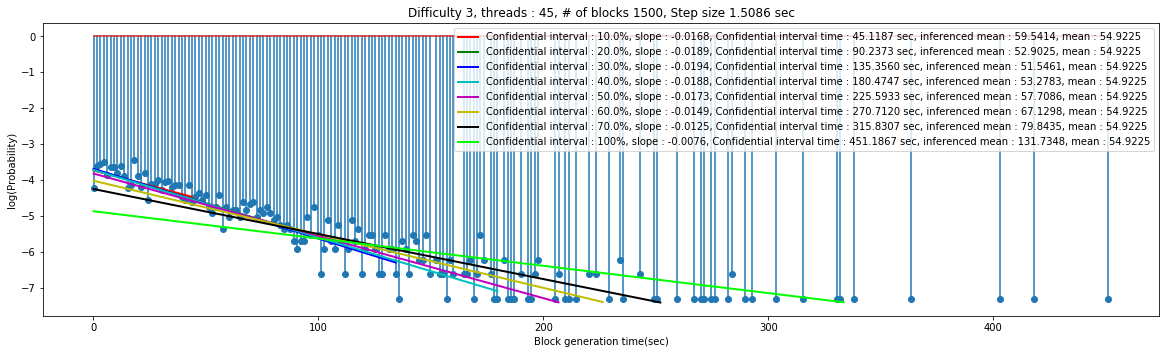

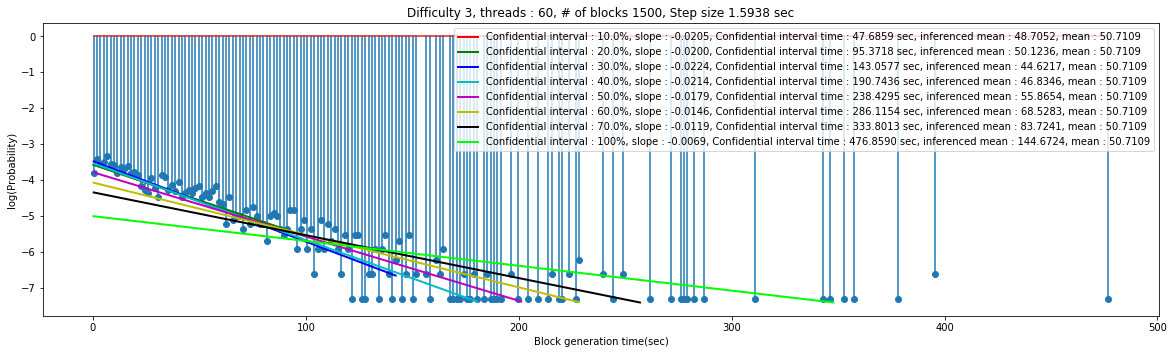

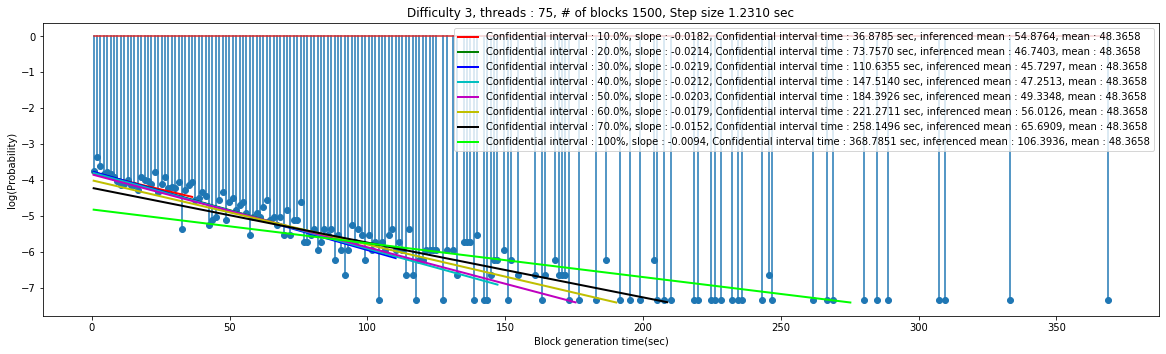

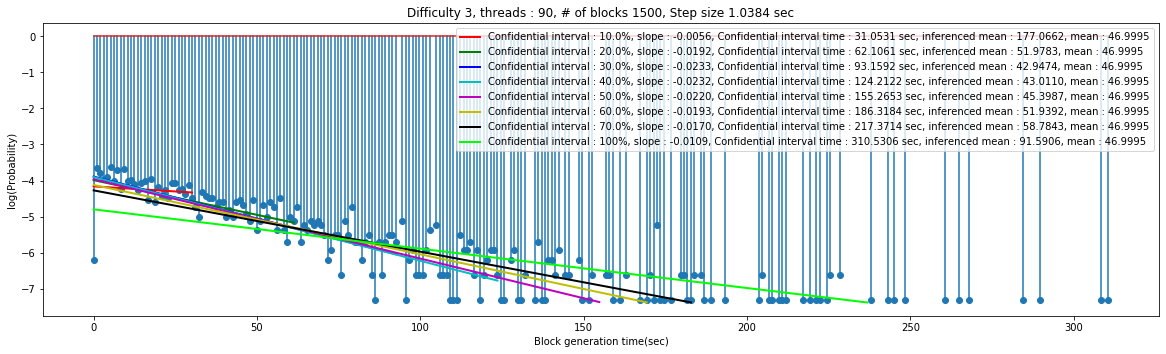

In [141]:
plt.rcParams["figure.figsize"] = (20,70)
num_of_bin = 300
confidential_interval = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1]
color = ['r-', 'g-', 'b-', 'c-', 'm-', 'y-', 'k-', 'lime']
for i in range(len(df_list)):
    x = df_list[i]['block_height']
    frame = df_list[i]['elapsed_time'].astype(float)
    time = bin_list[i][:-1]
    val = val_list[i]
    log_val = np.log((val)/(sum(val)))
    interpolated_val = np.where(val==0, np.min(val[np.nonzero(val)]), val)    
    interpolated_log_val = np.log((interpolated_val)/(sum(interpolated_val)))
    # * Delete -inf which happened because of log(0)
    #val_for_regression = np.where(np.isinf(val), 0, val)
    #val_for_regression = np.where(val_for_regression==0, np.min(val_for_regression), val_for_regression)

    regression_slope_list = []
    regression_time_list = []
    regression_result_list = []

    fig = plt.figure()
    ax = fig.add_subplot(11,1,i+1)    
    ax.set_title(f"Difficulty {difficulty[i]}, threads : {threads[i]}, # of blocks {len(np.array(frame))}, Step size {bin_list[i][1] - bin_list[i][0]:.4f} sec")
    #Each stick is {max(np.array(frame))/num_of_bin:.4f} sec
    ax.set_xlabel("Block generation time(sec)")
    ax.set_ylabel("log(Probability)")
    #plt.hist(frame, bins=num_of_bin, histtype='step')    
    plt.stem(time, log_val)    

    for i in range(len(confidential_interval)):
        slope, t, result = re.regress_with_conf_interval(time, interpolated_log_val, confidential_interval[i])
        regression_slope_list.append(slope)
        regression_time_list.append(t)
        regression_result_list.append(result)        

        # * For pretty plot
        min_log_val = np.min(interpolated_log_val)
        cutter_for_pretter = np.where(regression_result_list[i] < min_log_val)[0]
        if len(cutter_for_pretter) == 0:
            cutter_for_pretter = len(regression_result_list[i])
        else:
            cutter_for_pretter = cutter_for_pretter[0]  

        plt.plot(regression_time_list[i][:cutter_for_pretter], regression_result_list[i][:cutter_for_pretter],\
         color[i], label = f"Confidential interval : {confidential_interval[i]*100}%, slope : {slope :.4f}, Confidential interval time : {confidential_interval[i]*time[-1] :.4f} sec, inferenced mean : {abs(1/slope):.4f}, mean : {frame.mean():.4f}", linewidth=2)
    
    plt.legend(loc="upper right")

In [ ]:
plt.rcParams["figure.figsize"] = (10,70)
num_of_bin = 300
cumulative_val_list = []
bin_list = []
for i in range(len(df_list)):
    x = df_list[i]['block_height']
    frame = df_list[i]['elapsed_time'].astype(float)
    fig = plt.figure()
    ax = fig.add_subplot(11,1,i+1)    

    ax.set_title(f"Difficulty : {difficulty[i]}, threads : {threads[i]}, bins = {num_of_bin}")
    ax.set_xlabel("Block generation time")
    ax.set_ylabel("# of blocks")
    #plt.hist(frame, bins=num_of_bin, histtype='step')    
    val, bin, _ = plt.hist(frame, bins=num_of_bin, histtype='step', cumulative=True)    
    cumulative_val_list.append(val)
    bin_list.append(bin)
    #plt.legend(loc="upper left")

In [ ]:
plt.rcParams["figure.figsize"] = (20,70)
cumulative_dist = []
for i in range(len(df_list)):
    x = df_list[i]['block_height']
    frame = df_list[i]['elapsed_time'].astype(float)
    fig = plt.figure()
    ax = fig.add_subplot(11,1,i+1)    
    ax.set_title(f"Difficulty {difficulty[i]}, threads : {threads[i]}, # of blocks {len(np.array(frame))}, Step size {bin_list[i][1] - bin_list[i][0]:.4f} sec")
    #Each stick is {max(np.array(frame))/num_of_bin:.4f} sec

    textstr = '\n'.join((
        r'mean = %.4f' % (frame.mean()),
        r'var  = %.4f' % (frame.var()),
        r'std  = %.4f' % (frame.std()))
    )
    textbox = AnchoredText(textstr, loc=1)
    ax.add_artist(textbox)

    ax.set_xlabel("Block generation time(sec)")
    ax.set_ylabel("Probability(%)")
    #plt.hist(frame, bins=num_of_bin, histtype='step')    
    plt.plot(cumulative_val_list[i]/cumulative_val_list[i][-1])
    cumulative_dist.append(cumulative_val_list[i]/cumulative_val_list[i][-1])
    #plt.legend(loc="upper left")

In [ ]:
plt.rcParams["figure.figsize"] = (20,70)
num_of_bin = 300
confidential_interval = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
color = ['r-', 'g-', 'b-', 'c-', 'm-', 'y-', 'k-']
for i in range(len(df_list)):
    x = df_list[i]['block_height']
    frame = df_list[i]['elapsed_time'].astype(float)
    time = bin_list[i][:-1]
    val = cumulative_dist[i]
    log_val = np.log((val)/(sum(val)))
    interpolated_val = np.where(val==0, np.min(val[np.nonzero(val)]), val)    
    interpolated_log_val = np.log((interpolated_val)/(sum(interpolated_val)))
    # * Delete -inf which happened because of log(0)
    #val_for_regression = np.where(np.isinf(val), 0, val)
    #val_for_regression = np.where(val_for_regression==0, np.min(val_for_regression), val_for_regression)

    regression_slope_list = []
    regression_time_list = []
    regression_result_list = []

    fig = plt.figure()
    ax = fig.add_subplot(11,1,i+1)    
    ax.set_title(f"Difficulty {difficulty[i]}, threads : {threads[i]}, # of blocks {len(np.array(frame))}, Step size {bin_list[i][1] - bin_list[i][0]:.4f} sec")
    #Each stick is {max(np.array(frame))/num_of_bin:.4f} sec
    ax.set_xlabel("Block generation time(sec)")
    ax.set_ylabel("log(Probability(%))")
    #plt.hist(frame, bins=num_of_bin, histtype='step')    
    ax.stem(time, log_val)
    #plt.stem(time, log_val)    

    ax2 = ax.twinx()
    ax2.set_ylabel("# of blocks", color='orange')
    #plt.plot(time, val_list[i])
    ax2.hist(frame, bins=num_of_bin, histtype='step', color='orange')    
    #ax2.plot(time, val_list[i], 'orange')
    

    for i in range(len(confidential_interval)):
        slope, t, result = re.regress_with_conf_interval(time, interpolated_log_val, confidential_interval[i])
        regression_slope_list.append(slope)
        regression_time_list.append(t)
        regression_result_list.append(result)        

        # * For pretty plot
        min_log_val = np.min(interpolated_log_val)
        cutter_for_pretter = np.where(regression_result_list[i] < min_log_val)[0]
        if len(cutter_for_pretter) == 0:
            cutter_for_pretter = len(regression_result_list[i])
        else:
            cutter_for_pretter = cutter_for_pretter[0]  
        ax.plot(regression_time_list[i][:cutter_for_pretter], regression_result_list[i][:cutter_for_pretter],\
         color[i], label = f"Confidential interval : {confidential_interval[i]*100}%, Confidential interval time : {confidential_interval[i]*time[-1] :.4f} sec, slope : {slope :.4f}, inferenced mean : {1/slope:.4f}, mean : {frame.mean():.4f}", linewidth=2)
        '''
        plt.plot(regression_time_list[i][:cutter_for_pretter], regression_result_list[i][:cutter_for_pretter],\
         color[i], label = f"Confidential interval : {confidential_interval[i]*100}%, Confidential interval time : {confidential_interval[i]*time[-1] :.4f} sec, slope : {slope :.4f}, inferenced mean : {1/slope:.4f}, mean : {frame.mean():.4f}", linewidth=2)
        '''
    ax.legend(loc="upper right")